In [ ]:
# %pip install seaborn

In [1]:
# Initial imports and enviroment setup
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import os
sns.set()

if 'notebook' in os.getcwd():
    os.chdir('..')

# create grid world invironment
from src.env.gridworld import GridworldEnv

In [92]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

In [216]:
# Custom print to show state values inside the grid
def grid_print(V, k=None):
    ax = sns.heatmap(V.reshape(env.shape),
                     annot=True, square=True,
                     cbar=False, cmap='Blues',
                     xticklabels=False, yticklabels=False)

    if k:
        ax.set(title="State values after K = {0}".format(k))
    else:
        ax.set(title="State Values".format(k))
    plt.show()

class Video_callback:
    heatmap_params = dict(colorscale = 'Inferno',
                            zmin = rewards.min(),
                            zmax = rewards.max(),
                            texttemplate = '%{z}',
                            showlegend=False,
                            showscale=False,
                            )
    
    def __init__(self):
        
        self.frames = []
        self.titles = []

    def write(self, V, k=None):
        # Format array so that it render collectly
        self.frames.append(np.flip(V.reshape(simple_env.shape), axis = 0))
        self.titles.append(k)

    def plot(self):
        fig_dict = {
            "data": [],
            "layout": {
                            'xaxis': {'visible': False},
                            'yaxis': {'visible': False,
                                        'scaleanchor': 'x'}},
            "frames": []
        }
        fig_dict["layout"]["updatemenus"] = [
            {
                "buttons": [
                    {
                        "args": [None, {"frame": {"duration": 500, "redraw": True},
                                        "fromcurrent": True, "transition": {"duration": 300,
                                                                            "easing": "quadratic-in-out"}}],
                        "label": "Play",
                        "method": "animate"
                    },
                    {
                        "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                        "mode": "immediate",
                                        "transition": {"duration": 0}}],
                        "label": "Pause",
                        "method": "animate"
                    }
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 87},
                "showactive": False,
                "type": "buttons",
                "x": 0.1,
                "xanchor": "right",
                "y": 0,
                "yanchor": "top"
            }
        ]
        sliders_dict = {
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "font": {"size": 20},
                "prefix": "Iteration: ",
                "visible": True,
                "xanchor": "right"
            },
            "transition": {"duration": 300, "easing": "cubic-in-out"},
            "pad": {"b": 10, "t": 50},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": []
        }
        fig_dict['data'] = go.Frame(data=go.Heatmap(z=self.frames[0], **self.heatmap_params))['data']

        for i, arr in enumerate(self.frames):
            
            fig_dict["frames"].append(go.Frame(data=go.Heatmap(z=arr, **self.heatmap_params), name = str(i)))

            slider_step = {"args": [
                [i],
                {"frame": {"duration": 300, "redraw": True},
                "mode": "immediate",
                "transition": {"duration": 300}
                }
            ],
                "label": str(i),
                "method": "animate"}
            sliders_dict["steps"].append(slider_step)
        fig_dict["layout"]["sliders"] = [sliders_dict]
        fig = go.Figure(fig_dict)
        fig.update_traces(showlegend=False)
        fig.update(layout_showlegend=False)
        fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
        return fig
            


In [15]:
simple_env = np.array([ [-10,  0,  0,  0,  0, 50],
                        [  0,  0,  0,  0,  0,  0],
                        [ 20,  0,  0,-10,  0,  0],
                        [-10,  0,  0,  0,  0,  0]])
rewards = simple_env.flatten()
terminal_states = [i for i, x in enumerate(rewards) if not (x == 0)]

env = GridworldEnv(size = simple_env.shape, rewards = rewards, terminal_states = terminal_states)

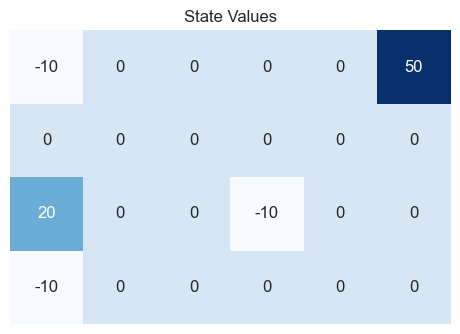

In [131]:
grid_print(env.rewards)

# Value updates

In [208]:
def update_values(env, V, discount_factor=1.0, verbose = 0, delta = 0, callback = None):
    V_new = np.copy(V)
    if verbose > 0:
        grid_print(V, k=0)
    if callback is not None:
        callback.write(np.copy(V_new))
    for s in range(env.nS):
        q = np.zeros(env.nA)
        # Look at the possible next actions
        for a in range(env.nA):
            # For each action, look at the possible next states
            # to calculate q[s,a]
            for prob, next_state, reward, done in env.P[s][a]:
                # Calculate the value for each action as per backup diagram
                if not done:
                    q[a] += prob*(reward + discount_factor * V[next_state])
                else:
                    q[a] += prob * reward

        # find the maximum value over all possible actions
        # and store updated state value
        V_new[s] = q.max()
        if verbose > 0:
            grid_print(V_new, k=s + 1)
        if callback is not None:
            callback.write(np.copy(V_new))
        # How much our value function changed (across any states)
        delta = max(delta, np.abs(V_new[s] - V[s]))
    return V_new, delta

# 1st Iteration of value updates

In [220]:
env.reset()
video_1 = Video_callback()

V0 = np.zeros(env.nS)
V_new, delta = update_values(env, V0, discount_factor=0.5, verbose = 0, callback = video_1)

In [218]:
len(video_1.frames)

25

In [219]:
video_1.plot()

# 2nd Interation of vlaue updates

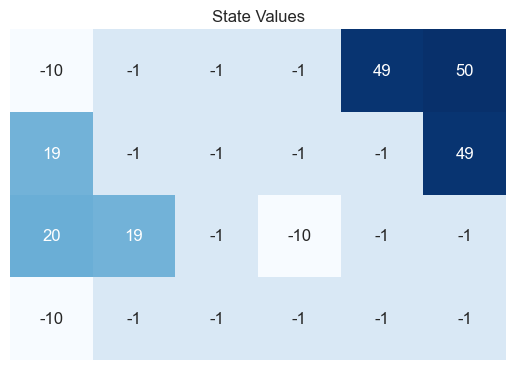

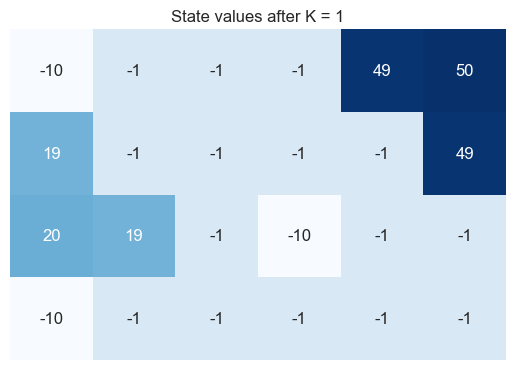

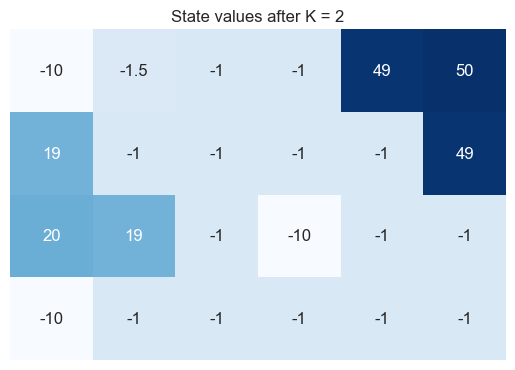

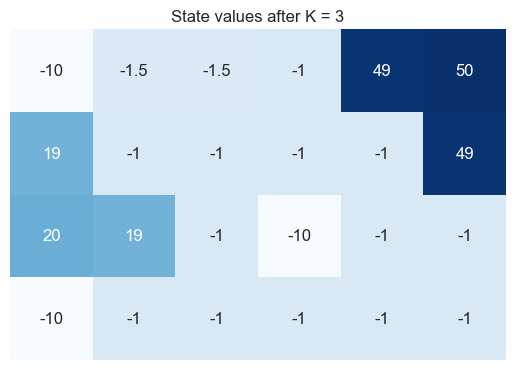

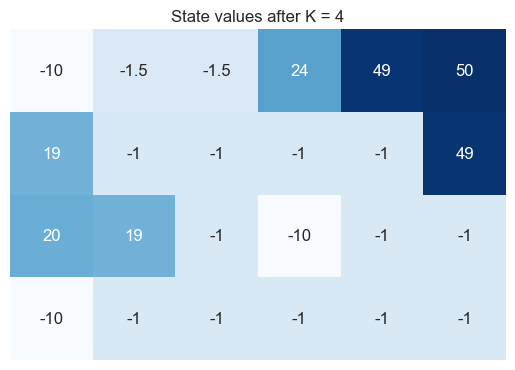

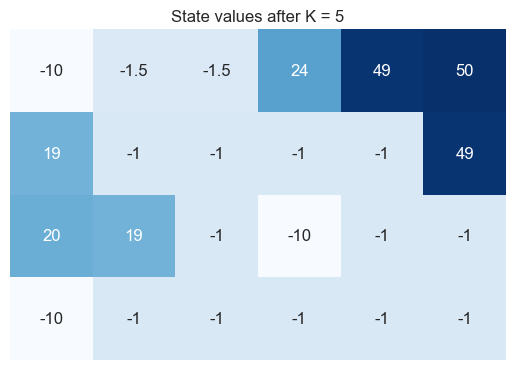

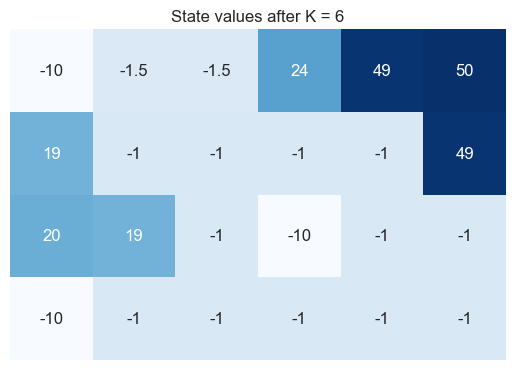

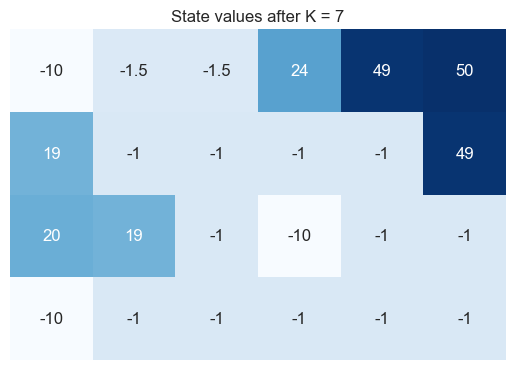

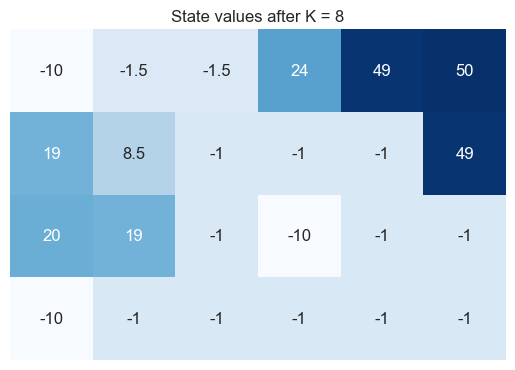

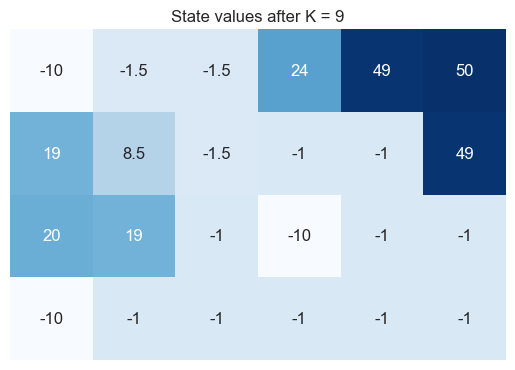

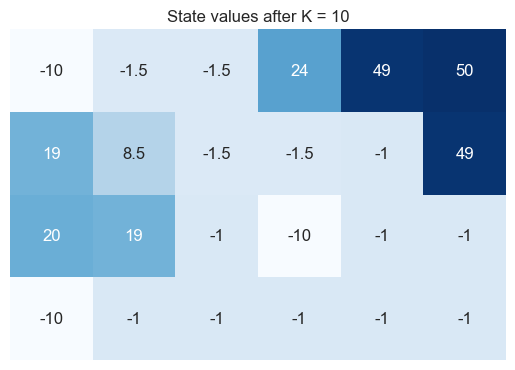

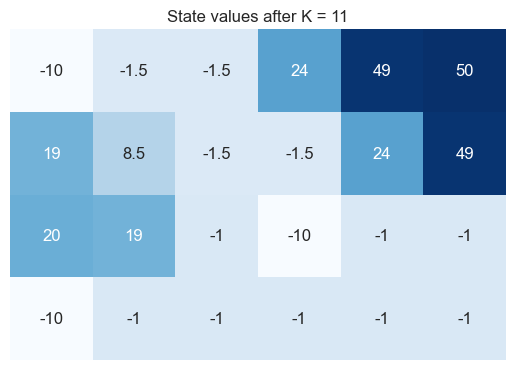

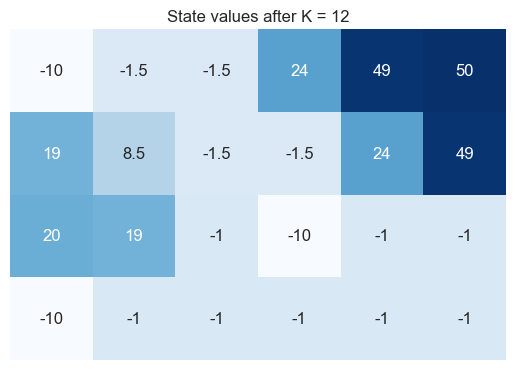

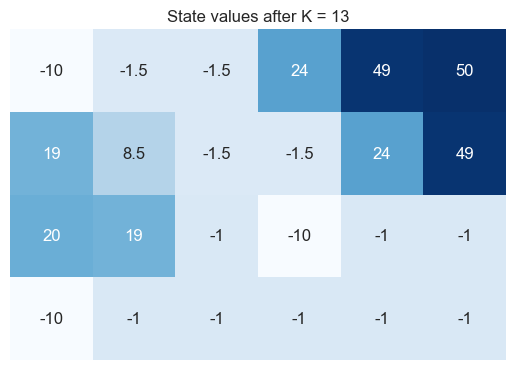

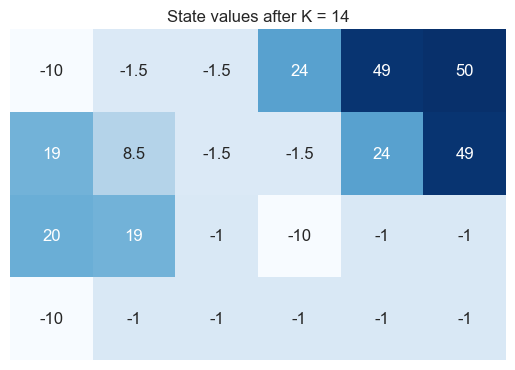

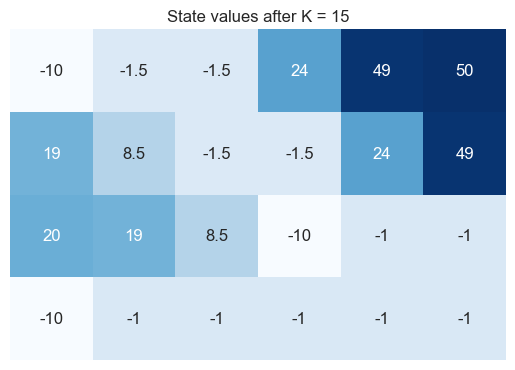

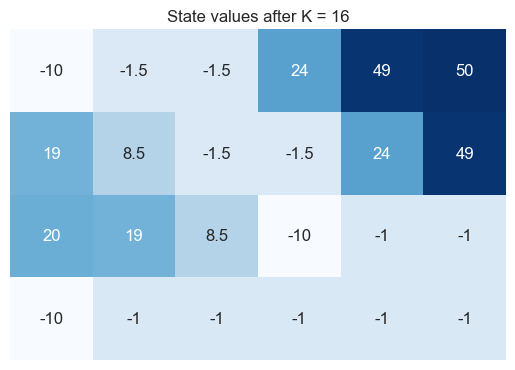

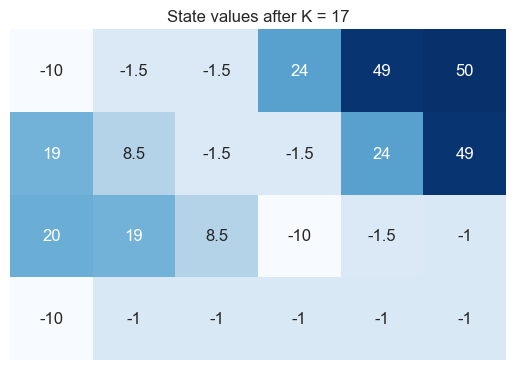

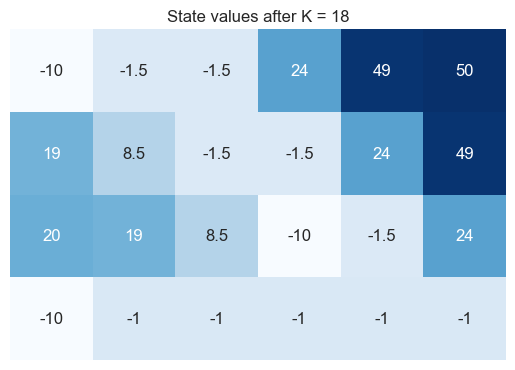

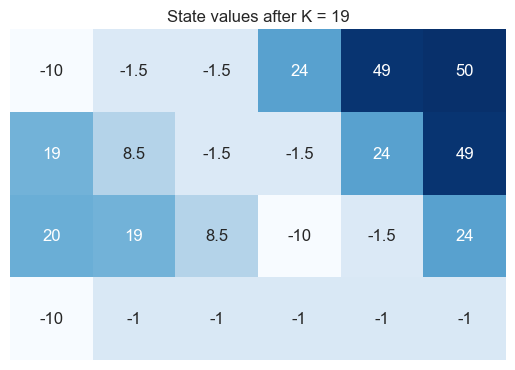

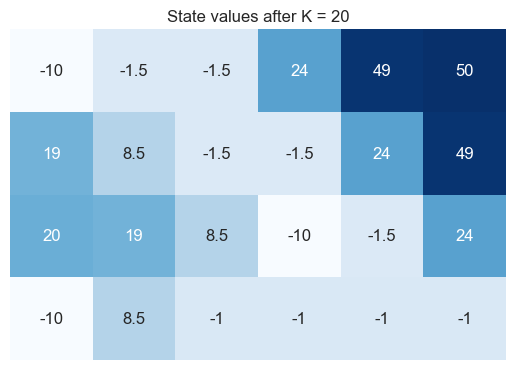

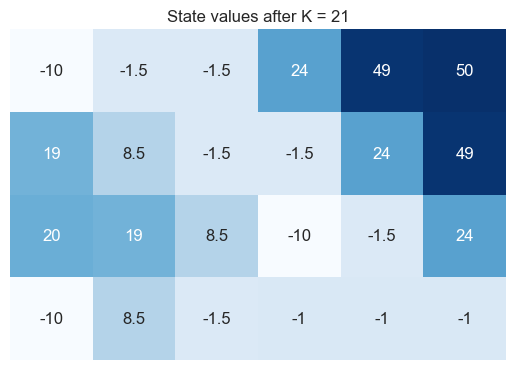

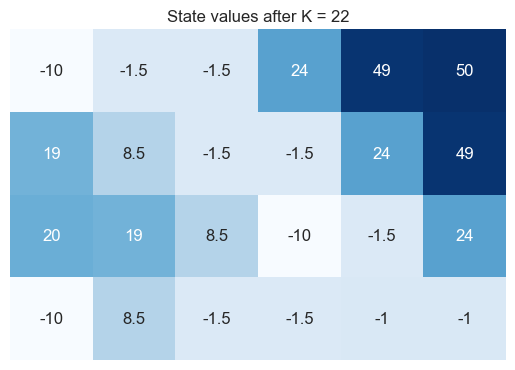

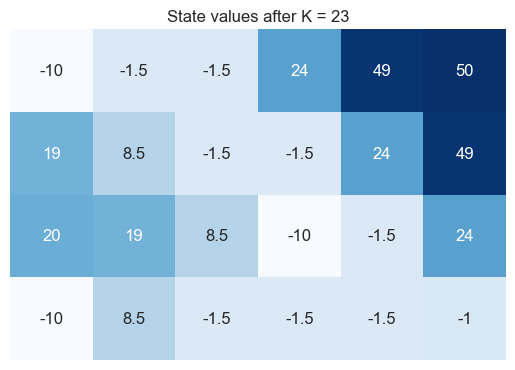

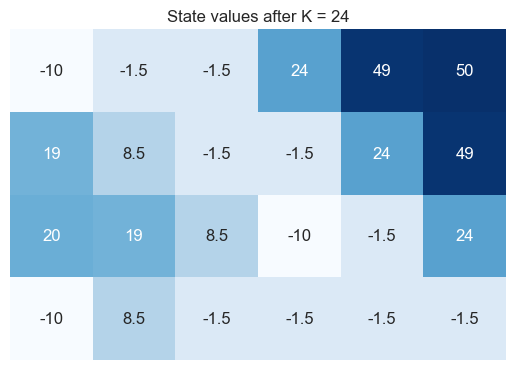

In [28]:
V_new, delta = update_values(env, V_new, discount_factor=0.5, verbose = 1)

# Full value iteration algorithm

In [ ]:
# Value Iteration
def value_iteration(env, discount_factor=1.0, theta=0.00001, verbose = 0):
    """
    Varry out Value iteration given an environment and a full description
    of the environment's dynamics.

    Args:
        env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        discount_factor: Gamma discount factor.
        theta: tolernace level to stop the iterations

    Returns:
        policy: [S, A] shaped matrix representing optimal policy.
        value : [S] length vector representing optimal value
    """

    def argmax_a(arr):
        """
        Return idx of max element in an array.
        """
        max_idx = []
        max_val = float('-inf')
        for idx, elem in enumerate(arr):
            if elem == max_val:
                max_idx.append(idx)
            elif elem > max_val:
                max_idx = [idx]
                max_val = elem
        return max_idx

    optimal_policy = np.zeros([env.nS, env.nA])
    V = np.zeros(env.nS)
    V_new = np.copy(V)
    i = 0
    if verbose > 0:
        grid_print(V_new, k=i)

    while True:
        i += 1
        delta = 0
        # For each state, perform a "greedy backup"
        V_new, delta = update_values(env, V, 
                                     discount_factor=1.0, 
                                     verbose = verbose - 1, 
                                     delta = delta)
        
        V = np.copy(V_new)
        if verbose > 0:
            grid_print(V_new, k=i)

        # Stop if change is below a threshold
        if delta < theta:
            break

    # V(s) has optimal values. Use these values and one step backup
    # to calculate optimal policy
    for s in range(env.nS):
        q = np.zeros(env.nA)
        # Look at the possible next actions
        for a in range(env.nA):
            # For each action, look at the possible next states
            # and calculate q[s,a]
            for prob, next_state, reward, done in env.P[s][a]:

                # Calculate the value for each action as per backup diagram
                if not done:
                    q[a] += prob * (reward + discount_factor * V[next_state])
                else:
                    q[a] += prob * reward

        # find the optimal actions
        # We are returning stochastic policy which will assign equal
        # probability to all those actions which are equal to maximum value
        best_actions = argmax_a(q)
        optimal_policy[s, best_actions] = 1.0 / len(best_actions)

    return optimal_policy, V

In [ ]:
# Run policy iteration on Grid world
pi_star, V_star = value_iteration(env, verbose = 1)

# Print Optimal policy
print("Optimal Policy\n", pi_star)

# Print optimal state values
grid_print(V_star.reshape(env.shape))